In [2]:
import pandas as pd
import numpy as np

import matplotlib.pyplot as plt
import seaborn as sns

from datetime import datetime

from statsmodels.api import tsa

from statsmodels.tsa.stattools import adfuller
from statsmodels.graphics.tsaplots import plot_pacf
from statsmodels.graphics.tsaplots import plot_acf

import statsmodels.api as sm
from statsmodels.tsa.statespace.sarimax import SARIMAX

from sklearn.metrics import mean_absolute_error
from statsmodels.api import qqplot

from sklearn.model_selection import train_test_split

%matplotlib inline

In [3]:
data = pd.read_csv('../peajes_caba.csv')

In [4]:
data

,estacion,fecha,cantidad_pasos
0,alberdi,1/1/2016,5446.0
1,alberdi,1/2/2016,6927.0
2,alberdi,1/3/2016,6630.0
3,alberdi,1/4/2016,9835.0
4,alberdi,1/5/2016,9091.0
...,...,...,...
1456,alberdi,12/27/2019,NaN
1457,alberdi,12/28/2019,NaN
1458,alberdi,12/29/2019,NaN
1459,alberdi,12/30/2019,NaN


In [5]:
data.fecha = data.fecha.astype(np.datetime64)
data['dayweek'] = data.fecha.dt.dayofweek
data.drop(columns='estacion',inplace=True)

In [6]:
data.head(5)

,fecha,cantidad_pasos,dayweek
0,2016-01-01,5446.0,4
1,2016-01-02,6927.0,5
2,2016-01-03,6630.0,6
3,2016-01-04,9835.0,0
4,2016-01-05,9091.0,1


In [7]:
data.isnull().mean()

fecha             0.000000
cantidad_pasos    0.125941
dayweek           0.000000
dtype: float64

<AxesSubplot:xlabel='fecha', ylabel='cantidad_pasos'>

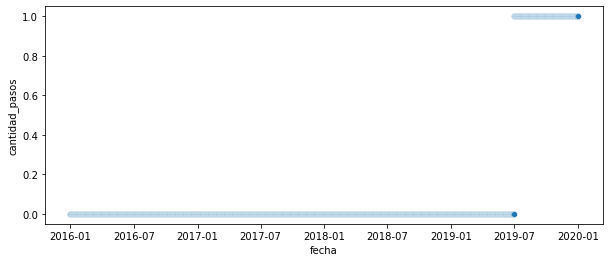

In [8]:
plt.figure(figsize=(10,4))
sns.scatterplot(y = data.cantidad_pasos.isnull(),x = data.fecha)

Se ve que solo hay datos faltantes en el periodo a predecir

<AxesSubplot:xlabel='fecha', ylabel='cantidad_pasos'>

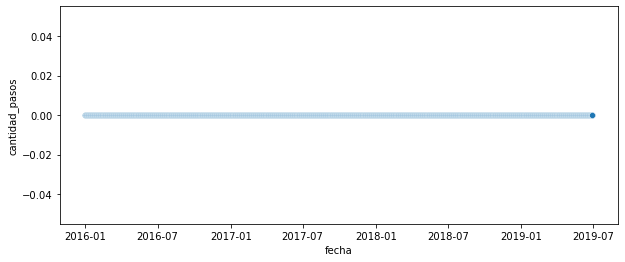

In [9]:
data_clean = data.copy().dropna()
plt.figure(figsize=(10,4))
sns.scatterplot(y = data_clean.cantidad_pasos.isnull(),x = data_clean.fecha)

<AxesSubplot:xlabel='fecha', ylabel='cantidad_pasos'>

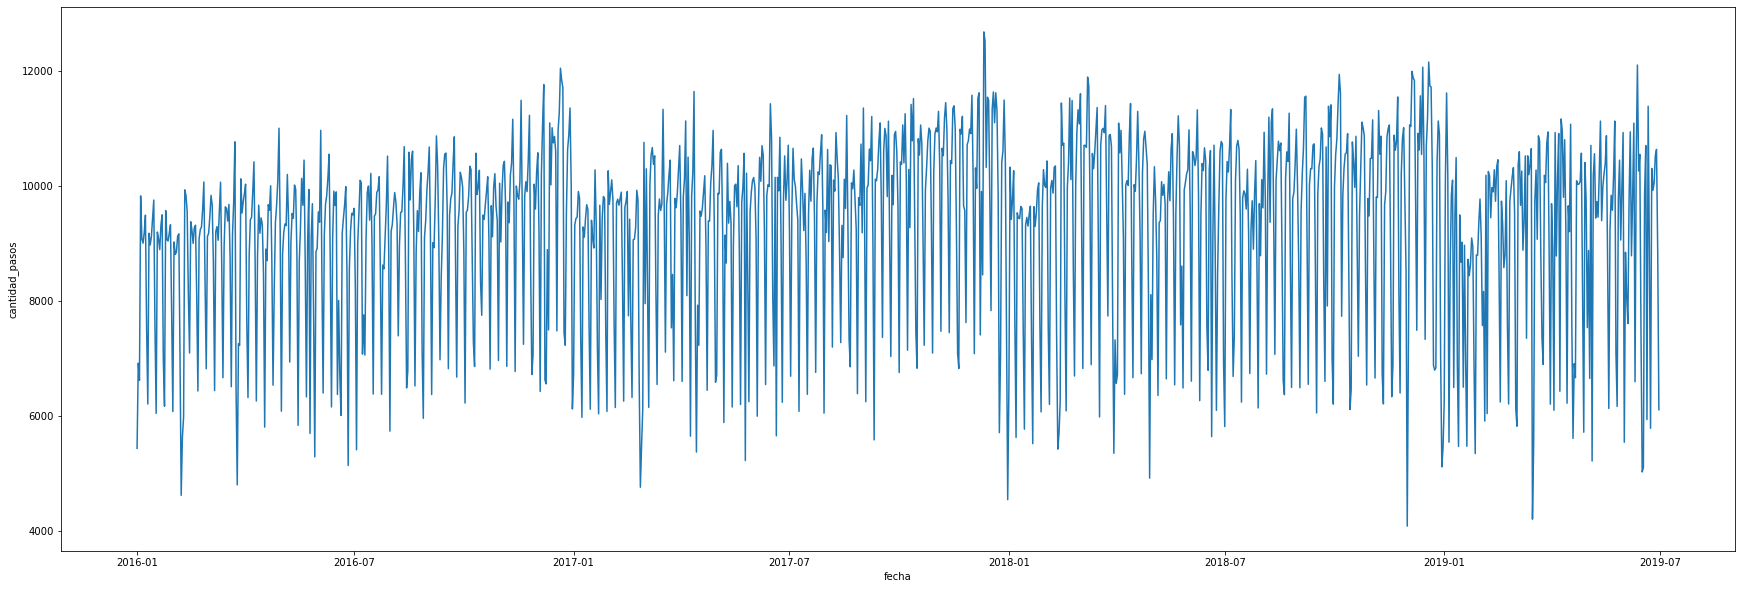

In [10]:
plt.figure(figsize=(30,10))
sns.lineplot(y=data_clean.cantidad_pasos,x=data_clean.fecha)

<AxesSubplot:xlabel='fecha', ylabel='cantidad_pasos'>

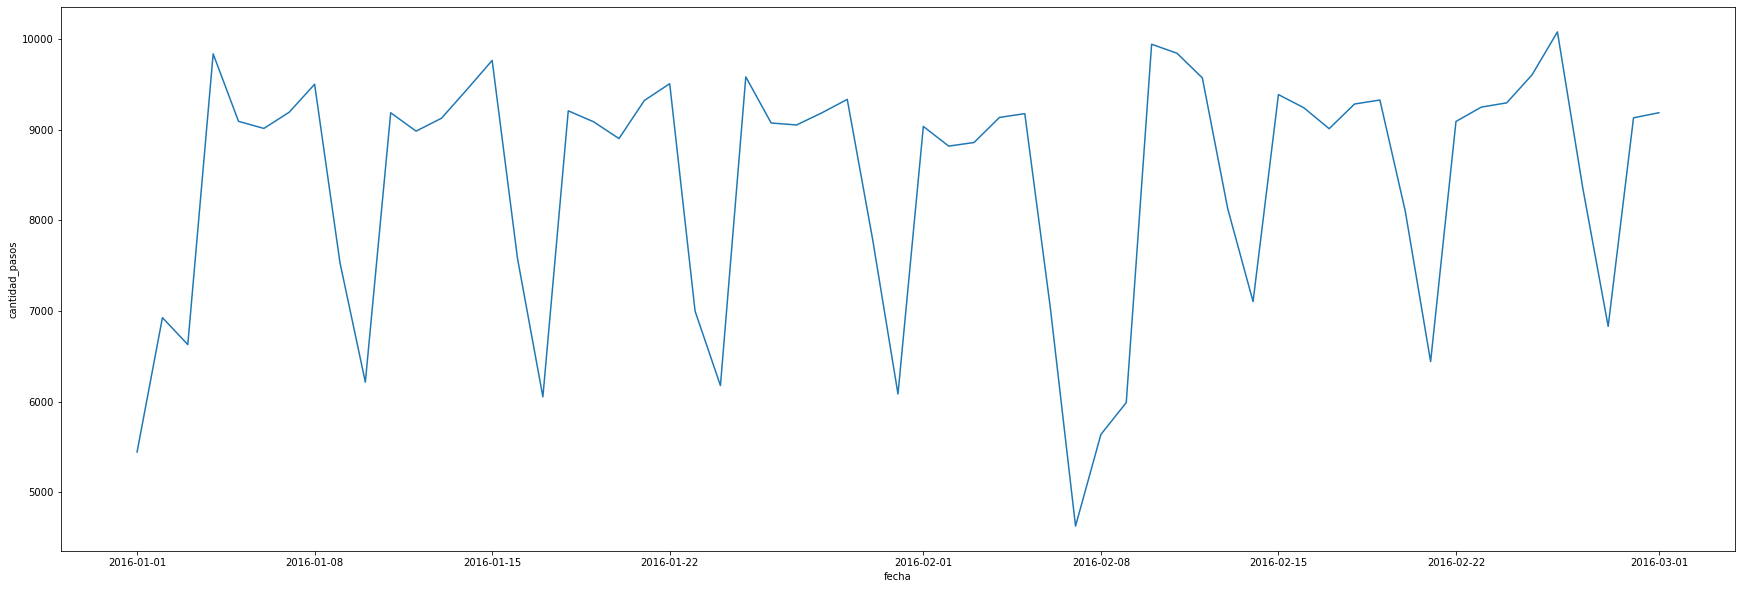

In [11]:
plt.figure(figsize=(30,10))
sns.lineplot(y=data_clean.loc[:,'cantidad_pasos'],x=data_clean.loc[:60,'fecha'])

<AxesSubplot:xlabel='dayweek', ylabel='cantidad_pasos'>

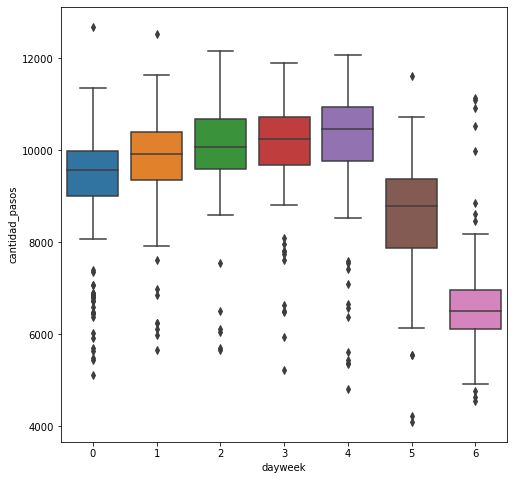

In [12]:
plt.figure(figsize=(8,8))
sns.boxplot(data=data_clean, y='cantidad_pasos',x='dayweek')

Se observan dos estaconalidades, una con frecuencia seguramente semanal y tambien una leve estacionalidad anual, marcada en enero y febrero con menor cantidad de pasos.

Tambien se observan outliers probablemente relacionados con dias feriados.

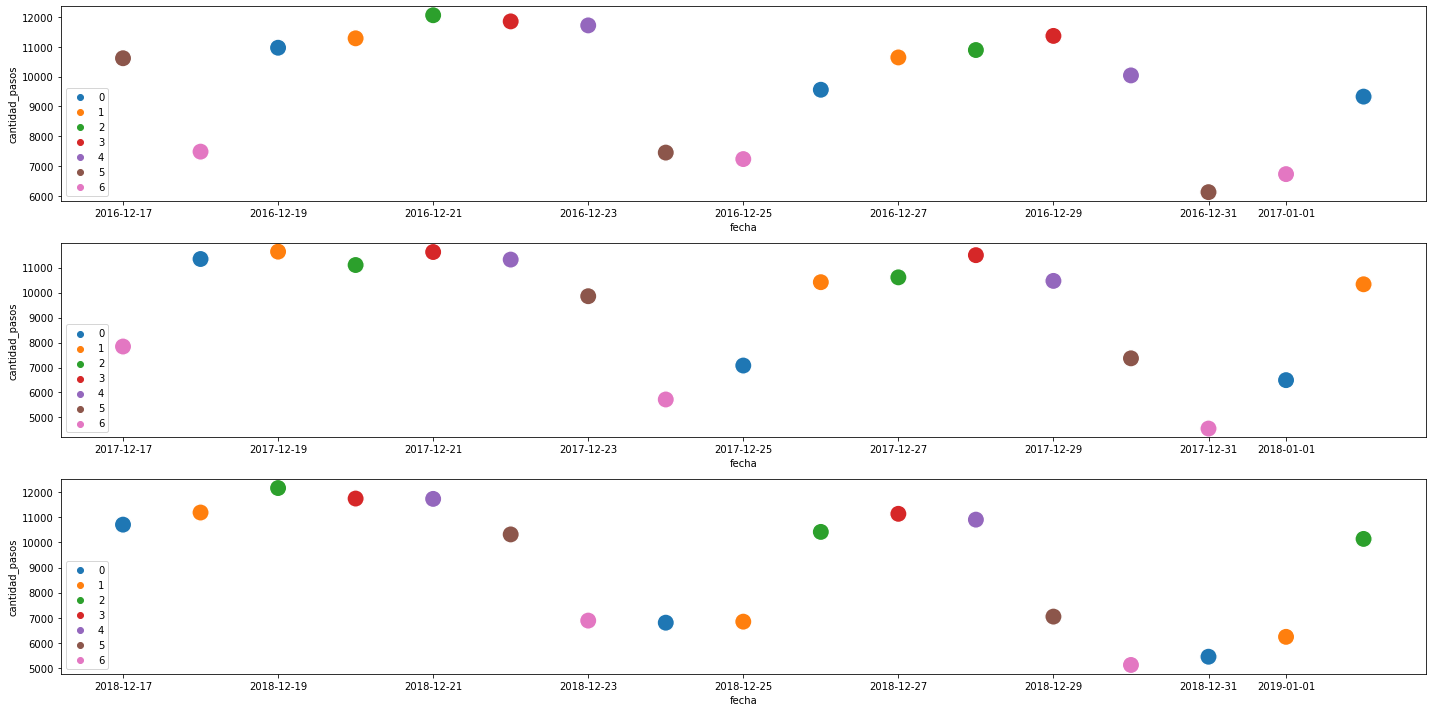

In [13]:
fig, [ax1,ax2,ax3] = plt.subplots(nrows=3,ncols=1,figsize=(20,10))
sns.scatterplot(data=data_clean.loc[351:365+2],y='cantidad_pasos',x='fecha',ax=ax1,hue='dayweek',palette='tab10',s=300)
ax1.legend(loc='lower left')
sns.scatterplot(data=data_clean.loc[351+365:365+365+2],y='cantidad_pasos',x='fecha',ax=ax2,hue='dayweek',palette='tab10',s=300)
ax2.legend(loc='lower left')
sns.scatterplot(data=data_clean.loc[351+365*2:365*3+2],y='cantidad_pasos',x='fecha',ax=ax3,hue='dayweek',palette='tab10',s=300)
ax3.legend(loc='lower left')
plt.tight_layout()

En los tres graficos se puede ver que los dias festivos de diciembre afectan la cantidad de pasos habitual de cada dia de la semana.

Utilizando la descopocision en tendencia, estacionalidad y ruido. Se puede ver la marcada estacionalidad semanal.

En la segunda descompocision se puede ver claramente un pico en la tendencia o quizas un ciclo.

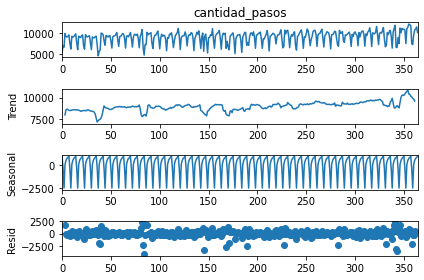

In [14]:
decomposed = tsa.seasonal_decompose(x=data_clean.cantidad_pasos[0:365],period=7)
decomposed.plot()
plt.show()

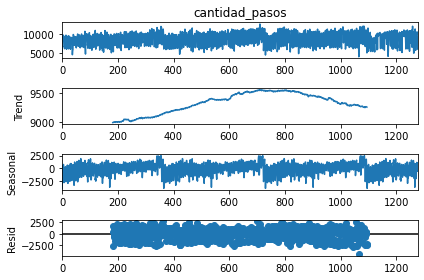

In [15]:
decomposed = tsa.seasonal_decompose(x=data_clean.cantidad_pasos,period=365)
decomposed.plot()
plt.show()

# **Prediccion con query**

La prediccion se realiza tomando el promedio de los dias de años anteriores. No se toma exactamente el mismo dia sino que se desfasan las series para que coincidan los dias de la semana, que presentan la estacionalidad mas marcada.

In [16]:
datetime.strptime('01-07-2019','%d-%m-%Y').weekday()

0

In [17]:
datetime.strptime('31-12-2019','%d-%m-%Y').weekday()

1

In [18]:
data_clean.set_index('fecha',inplace=True)
data_clean.head(2)

,cantidad_pasos,dayweek
fecha,,
2016-01-01,5446.0,4
2016-01-02,6927.0,5


In [19]:
slice_2016 = data_clean.loc['2016-07-04':'2017-01-03','cantidad_pasos'].values
data_clean.loc['2016-07-04'] #El primer dia es un lunes

cantidad_pasos    9002.0
dayweek              0.0
Name: 2016-07-04 00:00:00, dtype: float64

In [20]:
slice_2017 = data_clean.loc['2017-07-03':'2018-01-02','cantidad_pasos'].values
data_clean.loc['2017-07-03'] #El primer dia es un lunes

cantidad_pasos    9546.0
dayweek              0.0
Name: 2017-07-03 00:00:00, dtype: float64

In [21]:
slice_2018 = data_clean.loc['2018-07-02':'2019-01-01','cantidad_pasos'].values
data_clean.loc['2018-07-02'] #El primer dia es un lunes

cantidad_pasos    9788.0
dayweek              0.0
Name: 2018-07-02 00:00:00, dtype: float64

Text(0, 0.5, 'cantidad_pasos')

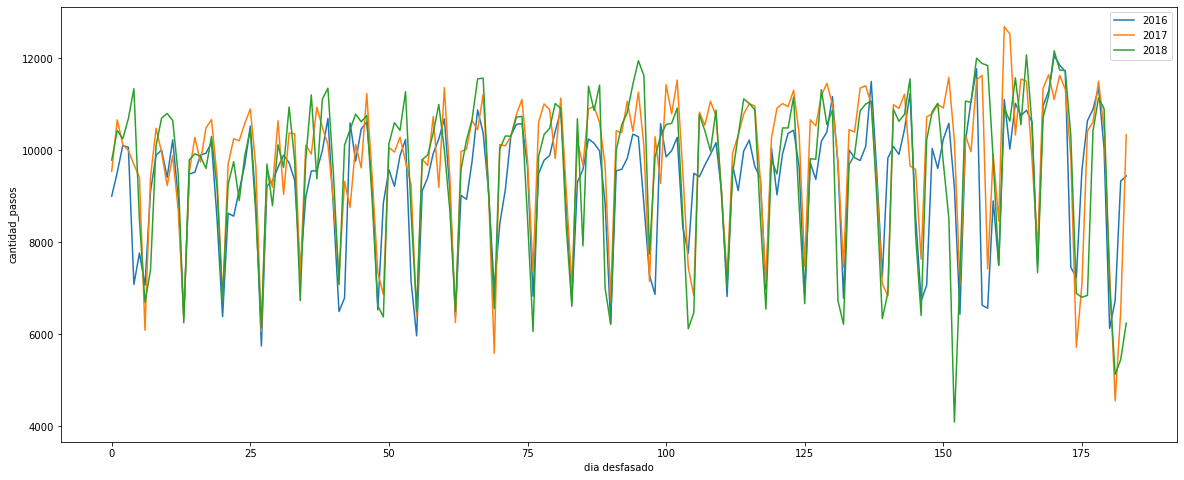

In [22]:
plt.figure(figsize=(20,8))
plt.plot(slice_2016,label='2016')
plt.plot(slice_2017,label='2017')
plt.plot(slice_2018,label='2018')
plt.legend()
plt.xlabel('dia desfasado')
plt.ylabel('cantidad_pasos')

In [23]:
data_prediction_f = data.copy().iloc[-len(slice_2016):]

data_prediction_f['cantidad_pasos'] = (slice_2016+slice_2017+slice_2018)/3

data_prediction_f.cantidad_pasos = np.round(data_prediction_f.cantidad_pasos).astype(int)

data_prediction_f['estacion'] = 'alberdi'

data_prediction_f.drop(columns='dayweek',inplace=True)

data_prediction_f = data_prediction_f.loc[:,['estacion','fecha','cantidad_pasos']]

data_prediction_f.to_csv('predicciones_julio_diciembre_2019.csv')

In [24]:
data_prediction_f

,estacion,fecha,cantidad_pasos
1277,alberdi,2019-07-01,9445
1278,alberdi,2019-07-02,10205
1279,alberdi,2019-07-03,10160
1280,alberdi,2019-07-04,10250
1281,alberdi,2019-07-05,9372
...,...,...,...
1456,alberdi,2019-12-27,10473
1457,alberdi,2019-12-28,6849
1458,alberdi,2019-12-29,5471
1459,alberdi,2019-12-30,7092


Text(0.5, 1.0, 'Prediccion query')

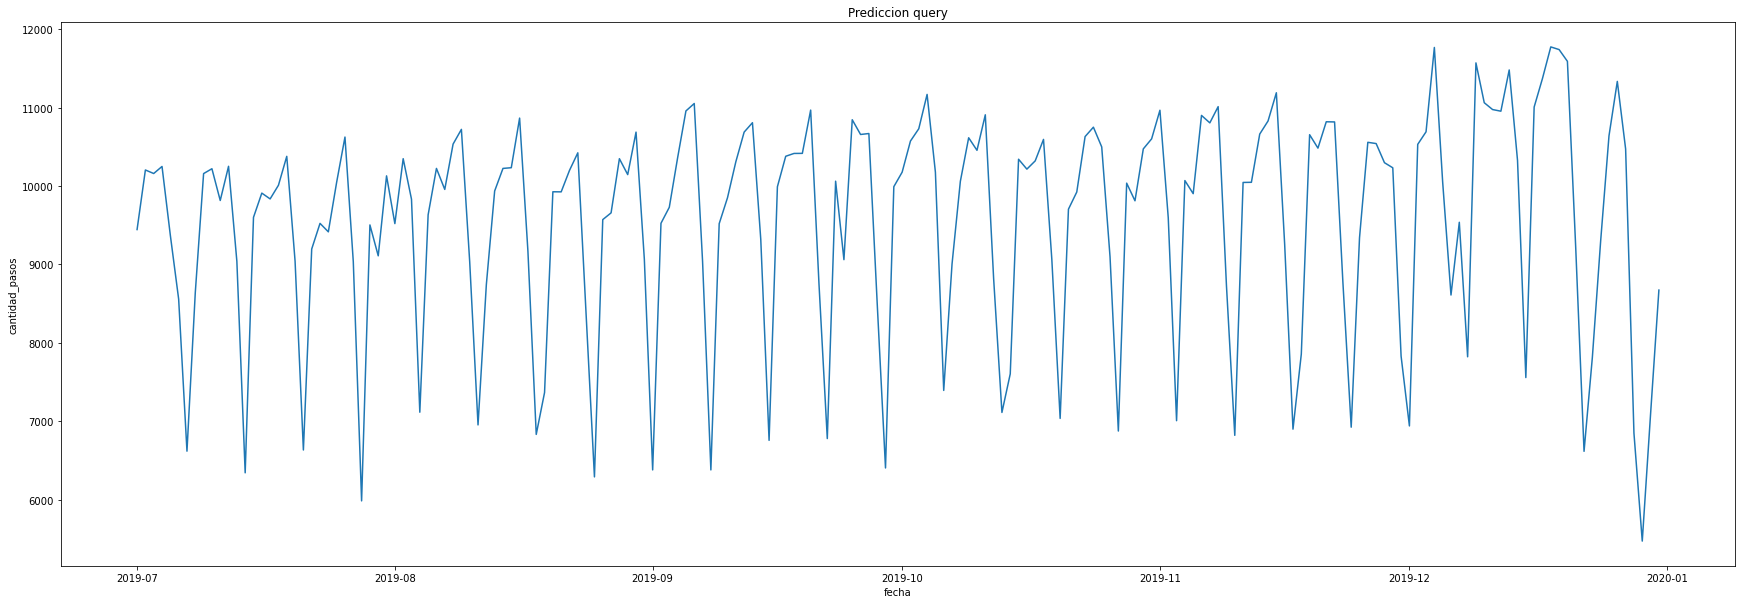

In [25]:
plt.figure(figsize=(30,10))
sns.lineplot(y=data_prediction_f.cantidad_pasos,x=data_prediction_f.fecha)
plt.title('Prediccion query')

# **Prediccion con modelo**

Exploramos la serie para ver si es factible utilizar un modelo SARIMA.

In [26]:
data_series = data_clean.cantidad_pasos
data_series

fecha
2016-01-01     5446.0
2016-01-02     6927.0
2016-01-03     6630.0
2016-01-04     9835.0
2016-01-05     9091.0
               ...   
2019-06-26    10064.0
2019-06-27    10532.0
2019-06-28    10644.0
2019-06-29     8892.0
2019-06-30     6117.0
Name: cantidad_pasos, Length: 1277, dtype: float64

In [27]:
train_size = int(np.round(data_series.shape[0] * 0.75))

data_train = data_series.iloc[:train_size]
data_test = data_series.iloc[train_size:]
print(data_train)
print(data_test)

fecha
2016-01-01     5446.0
2016-01-02     6927.0
2016-01-03     6630.0
2016-01-04     9835.0
2016-01-05     9091.0
               ...   
2018-08-11     9482.0
2018-08-12     7080.0
2018-08-13    10111.0
2018-08-14    10453.0
2018-08-15    10786.0
Name: cantidad_pasos, Length: 958, dtype: float64
fecha
2018-08-16    10621.0
2018-08-17    10756.0
2018-08-18     8874.0
2018-08-19     6620.0
2018-08-20     6379.0
               ...   
2019-06-26    10064.0
2019-06-27    10532.0
2019-06-28    10644.0
2019-06-29     8892.0
2019-06-30     6117.0
Name: cantidad_pasos, Length: 319, dtype: float64


<AxesSubplot:xlabel='fecha', ylabel='cantidad_pasos'>

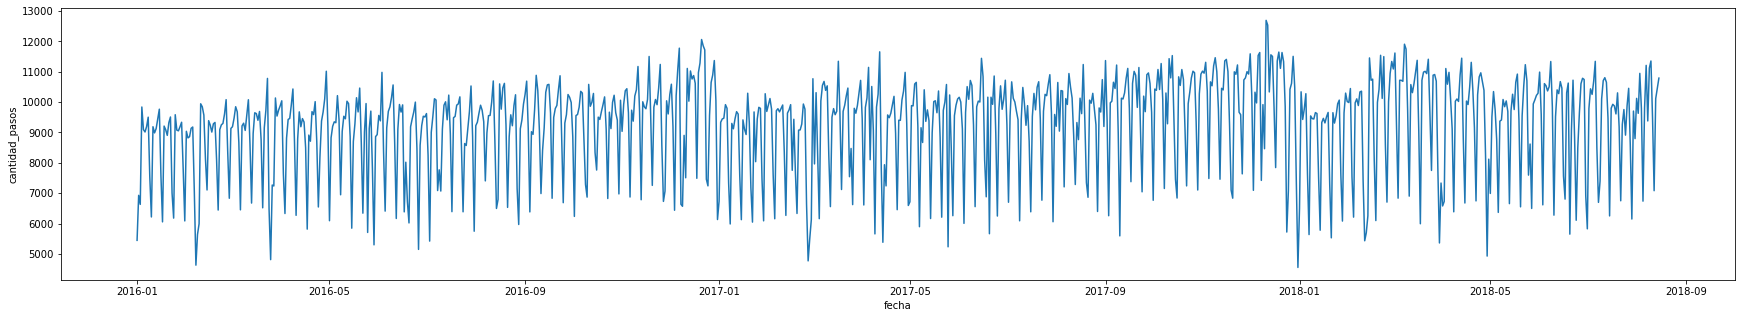

In [28]:
#volvemos a graficar los datos
plt.figure(figsize=(30,5))
sns.lineplot(y=data_train,x=data_train.index)

En un principio parece que los datos no tienen una tendencia solo las dos estacionalidades, semana y anual.

In [29]:
ad_fuller_result = adfuller(data_train)
print(f'ADF Statistic: {ad_fuller_result[0]}')
print(f'p-value: {ad_fuller_result[1]}')

ADF Statistic: -3.907115205500878
p-value: 0.0019831026603174453


Verificando con el test de Augmented Dickey-Fuller el p-value es bajo y pareceria no haber una tendencia.

A su vez graficando la media de 365 dias solo para los datos de testeo se puede ver una leve tendencia creciente. En rigor no deberiamos utilizarlo pero por la descompocision que hicimos anteriormente sabemos que esta tendencia tiene un maximo y vuelve a decrecer.

In [30]:
year_mean_series =  data_train.rolling(window=365).mean()
year_mean_series.dropna(inplace=True)

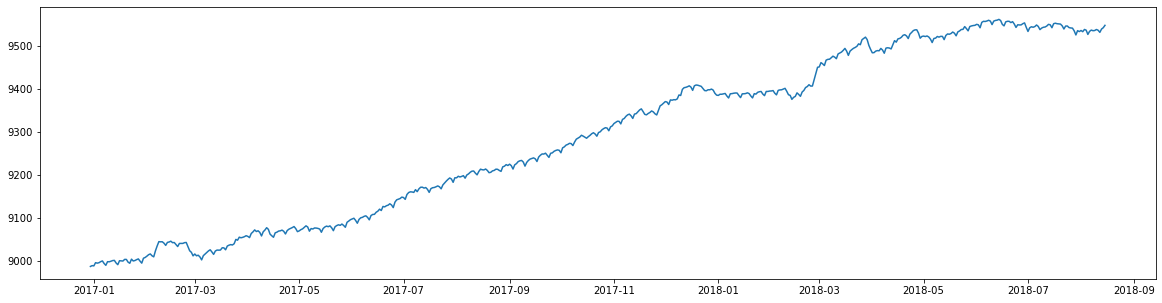

In [31]:
plt.figure(figsize=(20,5))
plt.plot(year_mean_series)

Verificamos los graficos de autocorrelacion y autocorrelacion parcial para estimar los parametros del modelo SARIMA

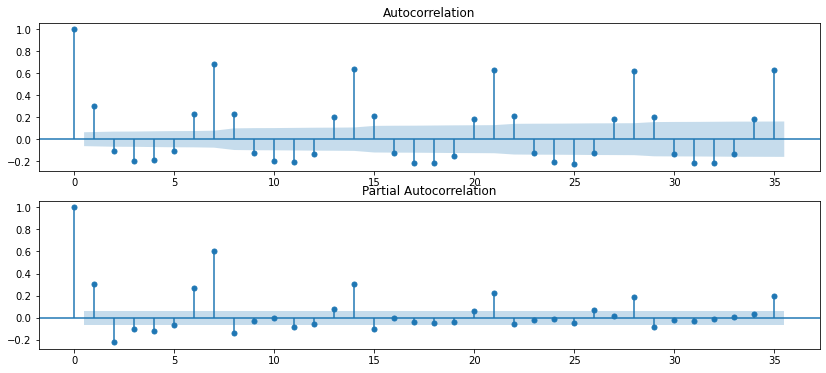

In [32]:
fig = plt.figure(figsize=(14,6))
ax1 = fig.add_subplot(211)
fig = sm.graphics.tsa.plot_acf(data_train,lags=35,ax=ax1)
ax2 = fig.add_subplot(212)
fig = sm.graphics.tsa.plot_pacf(data_train,lags=35,ax=ax2)

C:\anaconda3\envs\dhdsblend2021\lib\site-packages\statsmodels\regression\linear_model.py:1434: RuntimeWarning: invalid value encountered in sqrt
  return rho, np.sqrt(sigmasq)


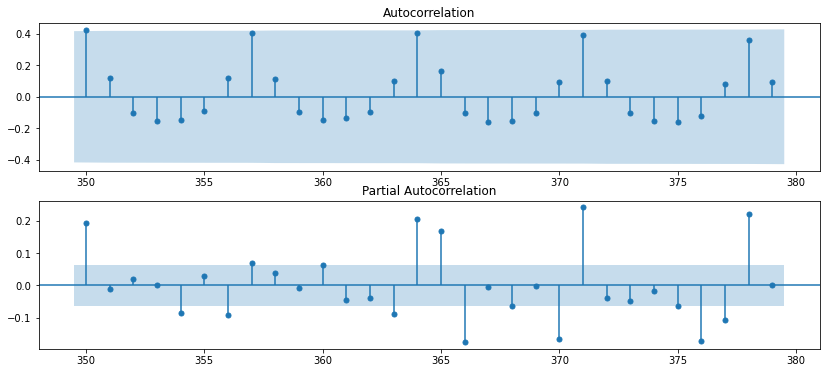

In [33]:
fig = plt.figure(figsize=(14,6))
ax1 = fig.add_subplot(211)
fig = sm.graphics.tsa.plot_acf(data_train,lags=range(350,380),ax=ax1)
ax2 = fig.add_subplot(212)
fig = sm.graphics.tsa.plot_pacf(data_train,lags=range(350,380),ax=ax2)

Verificando el grafico en el periodo de unas semanas se observa que hay una gran cantidad de puntos significativos y con la frecuencia de 7 dias. Ya que en ambos graficos ACF y PACF hay puntos significativos que al mismo tiempo decaen y cuentan con valores positivos y negaticos se opta por un modelo con parametros de AR1 y MA1. Tambien se verificaro otras combinaciones de parametros obteniendo p-values bajos solo para el modelo AR2, AM2.
En cuanto a los parametros estacionales se utilizo lag de 7 dias y coneficientes de AR1 y MA1, otras configuraciones dan altos p-values

In [34]:
my_order_1 = (1,0,1)
my_seasonal_order_1 = (1,0,1,7)

In [35]:
my_order_2 = (2,0,2)
my_seasonal_order_2 = (1,0,1,7)

In [36]:
sarimax_1 = SARIMAX(data_train, order=my_order_1, seasonal_order=my_seasonal_order_1)
sarimax_2 = SARIMAX(data_train, order=my_order_2, seasonal_order=my_seasonal_order_2)

C:\anaconda3\envs\dhdsblend2021\lib\site-packages\statsmodels\tsa\base\tsa_model.py:524: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  warnings.warn('No frequency information was'
C:\anaconda3\envs\dhdsblend2021\lib\site-packages\statsmodels\tsa\base\tsa_model.py:524: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  warnings.warn('No frequency information was'
C:\anaconda3\envs\dhdsblend2021\lib\site-packages\statsmodels\tsa\base\tsa_model.py:524: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  warnings.warn('No frequency information was'
C:\anaconda3\envs\dhdsblend2021\lib\site-packages\statsmodels\tsa\base\tsa_model.py:524: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  warnings.warn('No frequency information was'


In [37]:
sarimax_1_fit = sarimax_1.fit()
sarimax_2_fit = sarimax_2.fit()

C:\anaconda3\envs\dhdsblend2021\lib\site-packages\statsmodels\base\model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
C:\anaconda3\envs\dhdsblend2021\lib\site-packages\statsmodels\tsa\statespace\sarimax.py:966: UserWarning: Non-stationary starting autoregressive parameters found. Using zeros as starting parameters.
  warn('Non-stationary starting autoregressive parameters'


In [38]:
print(sarimax_1_fit.summary())

                                     SARIMAX Results                                     
Dep. Variable:                    cantidad_pasos   No. Observations:                  958
Model:             SARIMAX(1, 0, 1)x(1, 0, 1, 7)   Log Likelihood               -7911.406
Date:                           Thu, 12 May 2022   AIC                          15832.811
Time:                                   11:27:20   BIC                          15857.136
Sample:                               01-01-2016   HQIC                         15842.076
                                    - 08-15-2018                                         
Covariance Type:                             opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          0.9988      0.001    827.985      0.000       0.996       1.001
ma.L1         -0.8903      0.012    -74.716

In [39]:
print(sarimax_2_fit.summary())

                                      SARIMAX Results                                      
Dep. Variable:                      cantidad_pasos   No. Observations:                  958
Model:             SARIMAX(2, 0, 2)x(1, 0, [1], 7)   Log Likelihood               -8047.413
Date:                             Thu, 12 May 2022   AIC                          16108.826
Time:                                     11:27:20   BIC                          16142.880
Sample:                                 01-01-2016   HQIC                         16121.796
                                      - 08-15-2018                                         
Covariance Type:                               opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          1.9894      0.004    559.250      0.000       1.982       1.996
ar.L2         -0.9894      

Los p-value para los coeficientes de los modelos entrenados son bajos y los coeficientes distintos de 0. Es necesario verificar los residuos.

In [40]:
prediction_sarima_1 = sarimax_1_fit.forecast(len(data_test))
#prediction_sarima_1
prediction_sarima_2 = sarimax_2_fit.forecast(len(data_test))
prediction_sarima_2

2018-08-16    10212.556003
2018-08-17    10318.351632
2018-08-18     8783.745544
2018-08-19     6501.460077
2018-08-20     9414.945114
                  ...     
2019-06-26    10316.222613
2019-06-27    10409.814560
2019-06-28    10512.572306
2019-06-29     9003.619926
2019-06-30     6760.071459
Freq: D, Name: predicted_mean, Length: 319, dtype: float64

#### Sarima_1

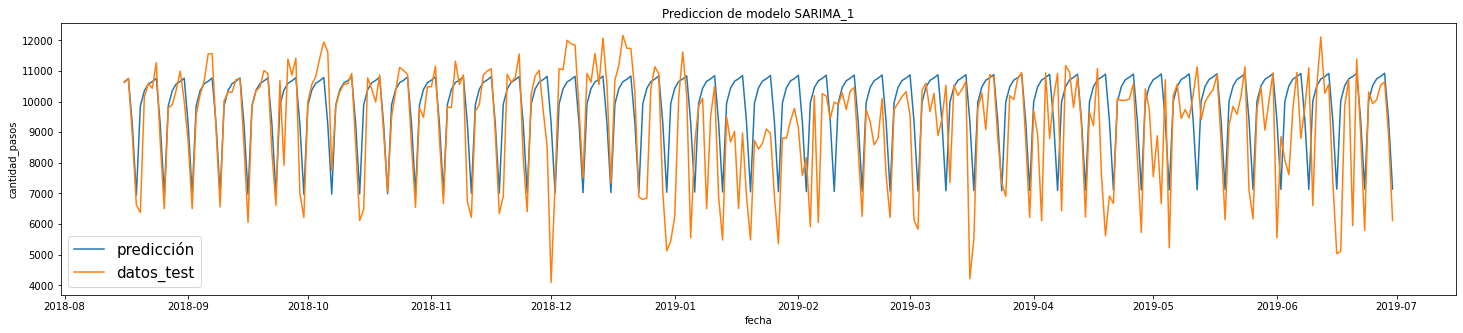

In [41]:
plt.figure(figsize=(25,5))
plt.plot(prediction_sarima_1,label='predicción')
plt.plot(data_series.iloc[-len(data_test):],label='datos_test')
plt.ylabel('cantidad_pasos')
plt.xlabel('fecha')
plt.title('Prediccion de modelo SARIMA_1')
plt.legend(loc="lower left",prop={'size': 15})

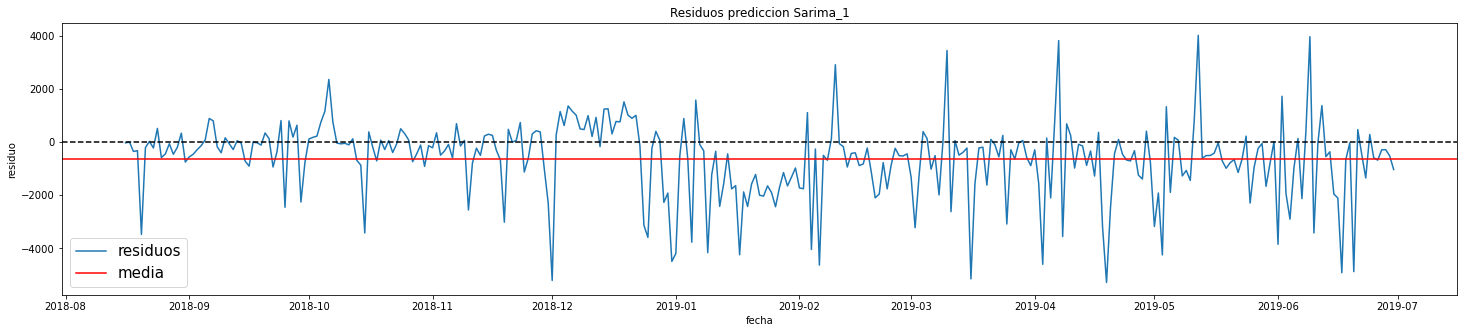

ME:  -622.6588516323854
MAE:  1048.3539566241323


In [42]:
plt.figure(figsize=(25,5))
residuals_sarima_1 = data_series.iloc[-len(data_test):] - prediction_sarima_1
plt.plot(residuals_sarima_1,label='residuos')
plt.axhline(residuals_sarima_1.mean(),c='r',label='media')
plt.axhline(0,linestyle='--',c='black')
plt.legend(loc="lower left",prop={'size': 15})
plt.title('Residuos prediccion Sarima_1')
plt.ylabel('residuo')
plt.xlabel('fecha')
plt.show()
print('ME: ',residuals_sarima_1.mean())
print('MAE: ', mean_absolute_error(data_series.iloc[-len(data_test):], prediction_sarima_1))

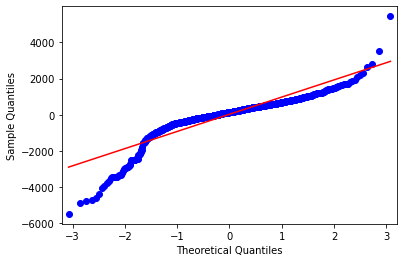

In [43]:
sm.ProbPlot(sarimax_1_fit.resid).qqplot(line='s')
plt.show()

#### Sarima_2

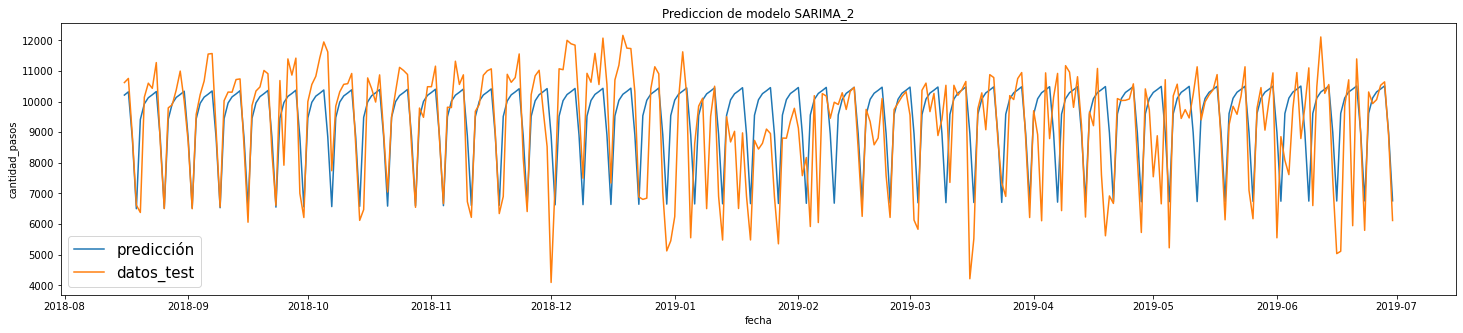

In [44]:
plt.figure(figsize=(25,5))
plt.plot(prediction_sarima_2,label='predicción')
plt.plot(data_series.iloc[-len(data_test):],label='datos_test')
plt.ylabel('cantidad_pasos')
plt.xlabel('fecha')
plt.title('Prediccion de modelo SARIMA_2')
plt.legend(loc="lower left",prop={'size': 15})

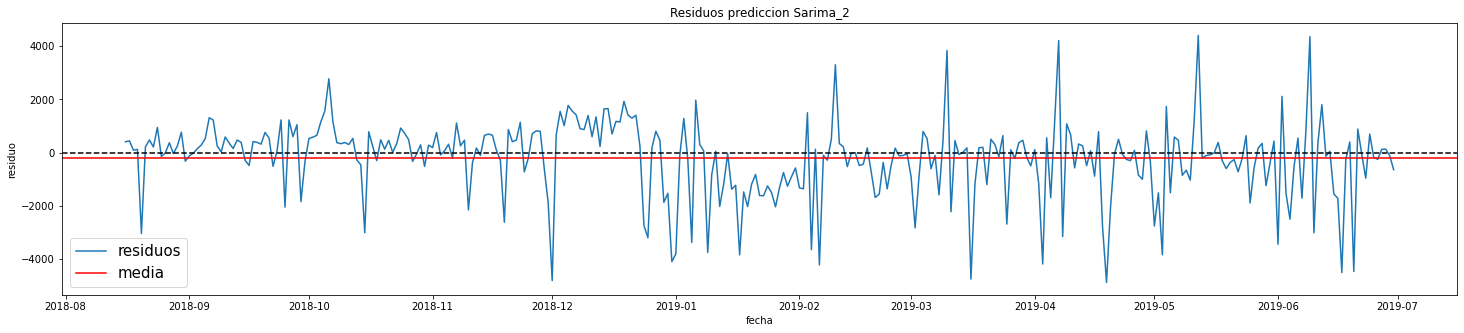

ME:  -219.00189012411474
MAE:  985.4991924816135


In [45]:
plt.figure(figsize=(25,5))
residuals_sarima_2 = data_series.iloc[-len(data_test):] - prediction_sarima_2
plt.plot(residuals_sarima_2,label='residuos')
plt.axhline(residuals_sarima_2.mean(),c='r',label='media')
plt.axhline(0,linestyle='--',c='black')
plt.legend(loc="lower left",prop={'size': 15})
plt.title('Residuos prediccion Sarima_2')
plt.ylabel('residuo')
plt.xlabel('fecha')
plt.show()
print('ME: ',residuals_sarima_2.mean())
print('MAE: ', mean_absolute_error(data_series.iloc[-len(data_test):], prediction_sarima_2))

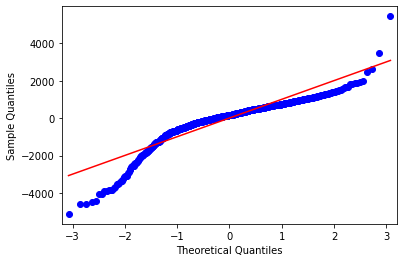

In [46]:
sm.ProbPlot(sarimax_2_fit.resid).qqplot(line='s')
plt.show()

Para ambos modelos los residuos de las predicciones tiene una media distinta de cero, ambos negativa y con errores absoluto medio similares.

Dados los QQplot se ve que los residuos no tienen dstribucion normal y por lo tanto los intervalo de confianza y p-values de los betas calculados no son confiables.

# Modelos lineales

A continuacion se plantean dos modelos de regression lineal generando distintas features que puedan explicar el comportamiento de la serie de tiempos

In [47]:
data_series

fecha
2016-01-01     5446.0
2016-01-02     6927.0
2016-01-03     6630.0
2016-01-04     9835.0
2016-01-05     9091.0
               ...   
2019-06-26    10064.0
2019-06-27    10532.0
2019-06-28    10644.0
2019-06-29     8892.0
2019-06-30     6117.0
Name: cantidad_pasos, Length: 1277, dtype: float64

A continuacion se genera el primer conjunto de features. Se utilizan dummies para el dia de la semana y el mes. En un principio se genero un feature n, que tomaba valores de 0 a 1 y sus potencia al cuadrado y al cubo pero el modelo ajusta mejor a los datos de test sin esas features. Tambien se elimino la feature de mes_2 ya que no era significativa respecto a la media(mes_1).

In [47]:
features = pd.DataFrame(index = data_series.index, data={'dia_semana':data_series.index.dayofweek,'mes':data_series.index.month,
                                                         'cte':np.ones(len(data_series)),'n':np.arange(len(data_series))/len(data_series)})
features['n2'] = features.n**2
features['n3'] = features.n**3
features = pd.get_dummies(data=features,columns=['dia_semana','mes'],drop_first=True)
features.drop(columns=['n','n2','n3','mes_2'],inplace=True) #,'mes_2'
features

,cte,dia_semana_1,dia_semana_2,dia_semana_3,dia_semana_4,dia_semana_5,dia_semana_6,mes_3,mes_4,mes_5,mes_6,mes_7,mes_8,mes_9,mes_10,mes_11,mes_12
fecha,,,,,,,,,,,,,,,,,
2016-01-01,1.0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0
2016-01-02,1.0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0
2016-01-03,1.0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0
2016-01-04,1.0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
2016-01-05,1.0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2019-06-26,1.0,0,1,0,0,0,0,0,0,0,1,0,0,0,0,0,0
2019-06-27,1.0,0,0,1,0,0,0,0,0,0,1,0,0,0,0,0,0
2019-06-28,1.0,0,0,0,1,0,0,0,0,0,1,0,0,0,0,0,0


In [48]:
X_train, X_test, y_train, y_test = train_test_split(features,data_series,shuffle=False,train_size=0.75)

In [49]:
modelo_lineal = sm.OLS(y_train,X_train).fit()

In [50]:
print(modelo_lineal.summary())

                            OLS Regression Results                            
Dep. Variable:         cantidad_pasos   R-squared:                       0.651
Model:                            OLS   Adj. R-squared:                  0.645
Method:                 Least Squares   F-statistic:                     109.5
Date:                Thu, 05 May 2022   Prob (F-statistic):          8.86e-202
Time:                        16:58:29   Log-Likelihood:                -7890.1
No. Observations:                 957   AIC:                         1.581e+04
Df Residuals:                     940   BIC:                         1.590e+04
Df Model:                          16                                         
Covariance Type:            nonrobust                                         
                   coef    std err          t      P>|t|      [0.025      0.975]
--------------------------------------------------------------------------------
cte           8786.3770    100.775     87.188   

In [51]:
predicciones_modelo_lineal = modelo_lineal.predict(X_test)

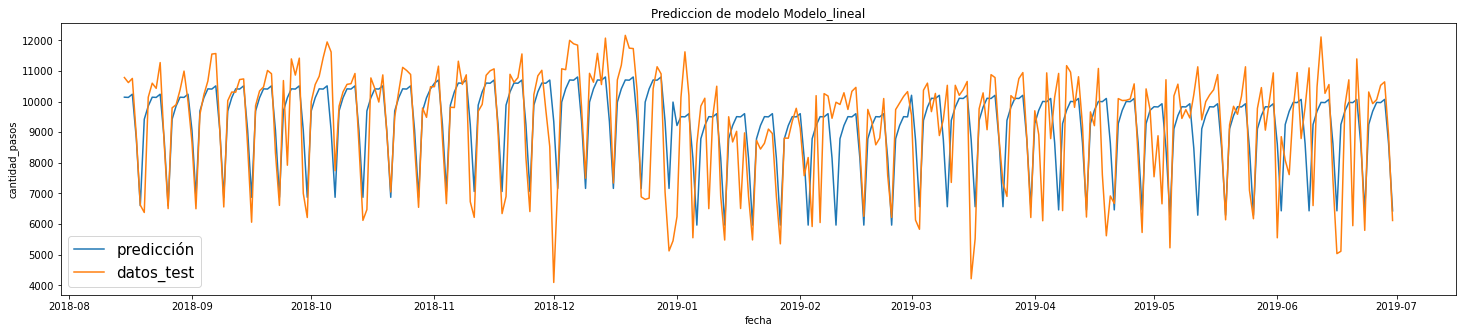

In [52]:
plt.figure(figsize=(25,5))
plt.plot(predicciones_modelo_lineal,label='predicción')
plt.plot(y_test,label='datos_test')
plt.ylabel('cantidad_pasos')
plt.xlabel('fecha')
plt.title('Prediccion de modelo Modelo_lineal')
plt.legend(loc="lower left",prop={'size': 15})

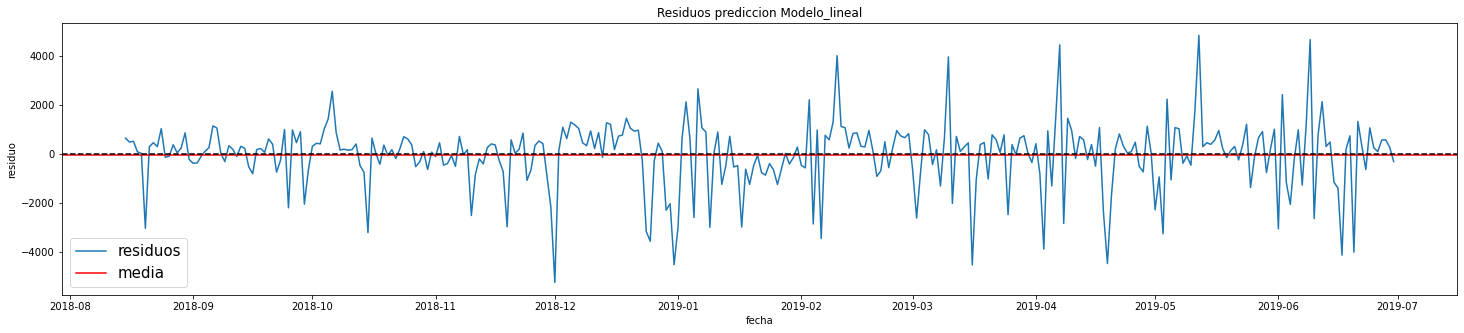

ME:  -42.96476329262301
MAE:  933.2720704124971


In [53]:
plt.figure(figsize=(25,5))
residuals_modelo_lineal = y_test - predicciones_modelo_lineal
plt.plot(residuals_modelo_lineal,label='residuos')
plt.axhline(residuals_modelo_lineal.mean(),c='r',label='media')
plt.axhline(0,linestyle='--',c='black')
plt.legend(loc="lower left",prop={'size': 15})
plt.title('Residuos prediccion Modelo_lineal')
plt.ylabel('residuo')
plt.xlabel('fecha')
plt.show()
print('ME: ',residuals_modelo_lineal.mean())
print('MAE: ', mean_absolute_error(y_test, predicciones_modelo_lineal))

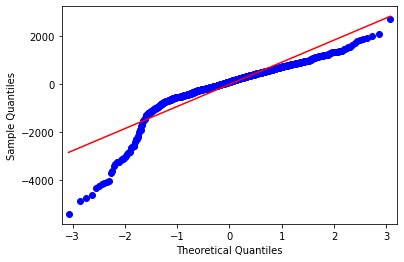

In [54]:
sm.ProbPlot(modelo_lineal.resid).qqplot(line='s')
plt.show()

In [55]:
predicciones_modelo_lineal_train_test = modelo_lineal.predict(features)

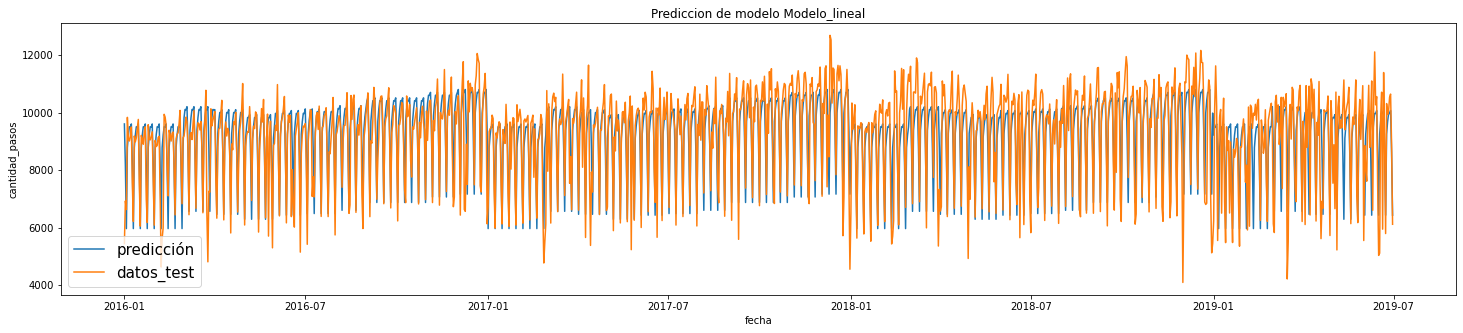

In [56]:
plt.figure(figsize=(25,5))
plt.plot(predicciones_modelo_lineal_train_test,label='predicción')
plt.plot(data_series,label='datos_test')
plt.ylabel('cantidad_pasos')
plt.xlabel('fecha')
plt.title('Prediccion de modelo Modelo_lineal')
plt.legend(loc="lower left",prop={'size': 15})

#### Segundo conjunto de features

Nuevamente incorporar la feature n y sus potnecias no genera tan buenas predicciones y al ser una aproximacion polinomica que se va a utilizar fuera del rango que se calculo es esperable que traiga errores exagerando el efecto ciclico de promedio anual.

A diferencia del mmodelo anterior en vez de utilizar variables dummies para el dia del año se utiliza el numero del dia y sus potencias. Por mas de dar resultados muy similares es preferible utilizar las variables dummies ya que no conocemos el comportamiento del polinomio en las fechas posteriores a las que se entreno.

In [57]:
features_2 = pd.DataFrame(index = data_series.index, data={'dia_semana':data_series.index.dayofweek,'cte':np.ones(len(data_series)),
                                                         'dia_año':data_series.index.dayofyear})#'n':np.arange(len(data_series))/len(data_series),
#features_2['n2'] = features_2.n**2
#features_2['n3'] = features_2.n**3
features_2['dia_año2'] = features_2.dia_año**2
features_2['dia_año3'] = features_2.dia_año**3
#features_2['dia_año4'] = features_2.dia_año**4
features_2 = pd.get_dummies(data=features_2,columns=['dia_semana'],drop_first=True)
#features.drop(columns=['n2','mes_2'],inplace=True)
features_2

,cte,dia_año,dia_año2,dia_año3,dia_semana_1,dia_semana_2,dia_semana_3,dia_semana_4,dia_semana_5,dia_semana_6
fecha,,,,,,,,,,
2016-01-01,1.0,1,1,1,0,0,0,1,0,0
2016-01-02,1.0,2,4,8,0,0,0,0,1,0
2016-01-03,1.0,3,9,27,0,0,0,0,0,1
2016-01-04,1.0,4,16,64,0,0,0,0,0,0
2016-01-05,1.0,5,25,125,1,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...
2019-06-26,1.0,177,31329,5545233,0,1,0,0,0,0
2019-06-27,1.0,178,31684,5639752,0,0,1,0,0,0
2019-06-28,1.0,179,32041,5735339,0,0,0,1,0,0


In [58]:
X_train, X_test, y_train, y_test = train_test_split(features_2,data_series,shuffle=False,train_size=0.75)

In [59]:
modelo_lineal_2 = sm.OLS(y_train,X_train).fit()

In [60]:
print(modelo_lineal_2.summary())

                            OLS Regression Results                            
Dep. Variable:         cantidad_pasos   R-squared:                       0.642
Model:                            OLS   Adj. R-squared:                  0.639
Method:                 Least Squares   F-statistic:                     188.8
Date:                Thu, 05 May 2022   Prob (F-statistic):          2.21e-204
Time:                        16:58:31   Log-Likelihood:                -7902.0
No. Observations:                 957   AIC:                         1.582e+04
Df Residuals:                     947   BIC:                         1.587e+04
Df Model:                           9                                         
Covariance Type:            nonrobust                                         
                   coef    std err          t      P>|t|      [0.025      0.975]
--------------------------------------------------------------------------------
cte           8675.5236    137.073     63.291   

In [61]:
predicciones_modelo_lineal_2 = modelo_lineal_2.predict(X_test)

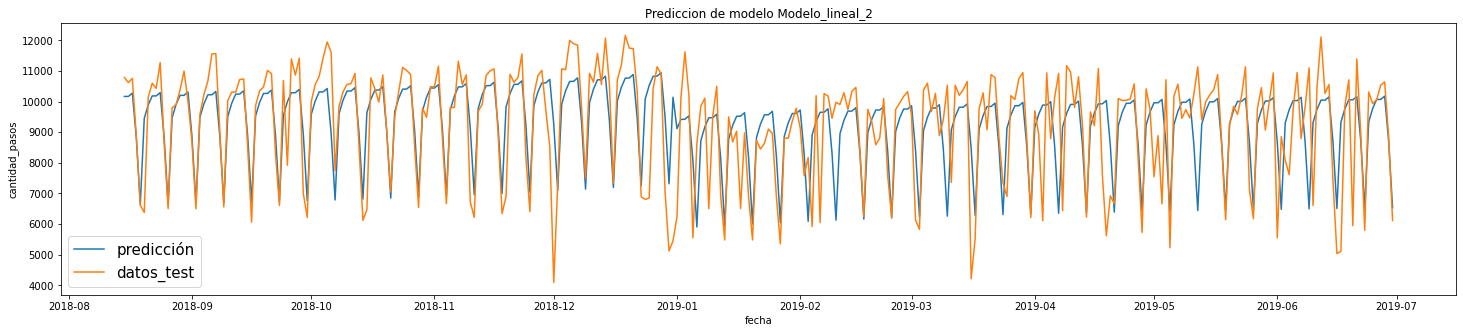

In [62]:
plt.figure(figsize=(25,5))
plt.plot(predicciones_modelo_lineal_2,label='predicción')
plt.plot(y_test,label='datos_test')
plt.ylabel('cantidad_pasos')
plt.xlabel('fecha')
plt.title('Prediccion de modelo Modelo_lineal_2')
plt.legend(loc="lower left",prop={'size': 15})

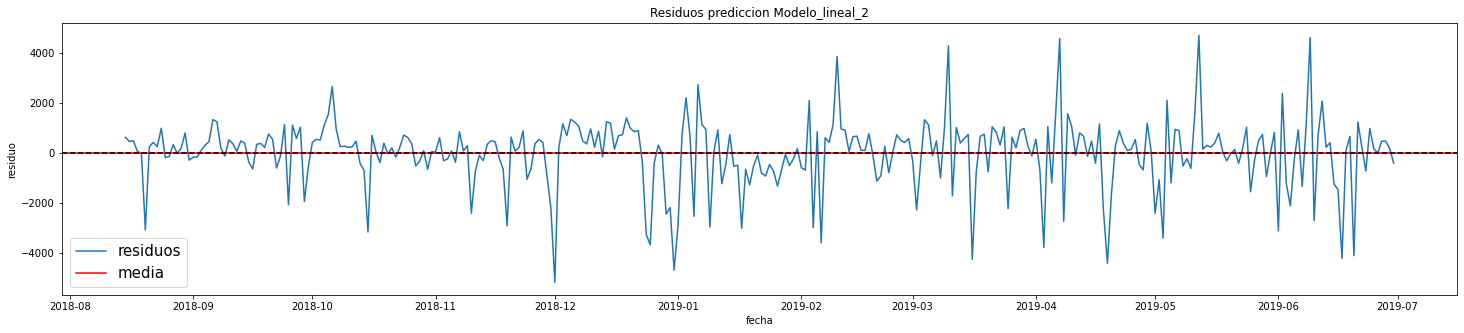

ME:  -27.020801052550404
MAE:  937.1385053985829


In [63]:
plt.figure(figsize=(25,5))
residuals_modelo_lineal_2 = y_test - predicciones_modelo_lineal_2
plt.plot(residuals_modelo_lineal_2,label='residuos')
plt.axhline(residuals_modelo_lineal_2.mean(),c='r',label='media')
plt.axhline(0,linestyle='--',c='black')
plt.legend(loc="lower left",prop={'size': 15})
plt.title('Residuos prediccion Modelo_lineal_2')
plt.ylabel('residuo')
plt.xlabel('fecha')
plt.show()
print('ME: ',residuals_modelo_lineal_2.mean())
print('MAE: ', mean_absolute_error(y_test, predicciones_modelo_lineal_2))

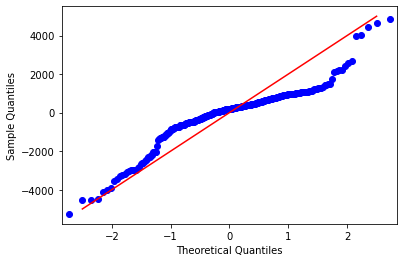

In [64]:
qqplot(residuals_modelo_lineal)
plt.plot([-2.5,2.5],[-5000,5000],c='r')
plt.show()

In [65]:
predicciones_modelo_lineal = modelo_lineal.predict(features)

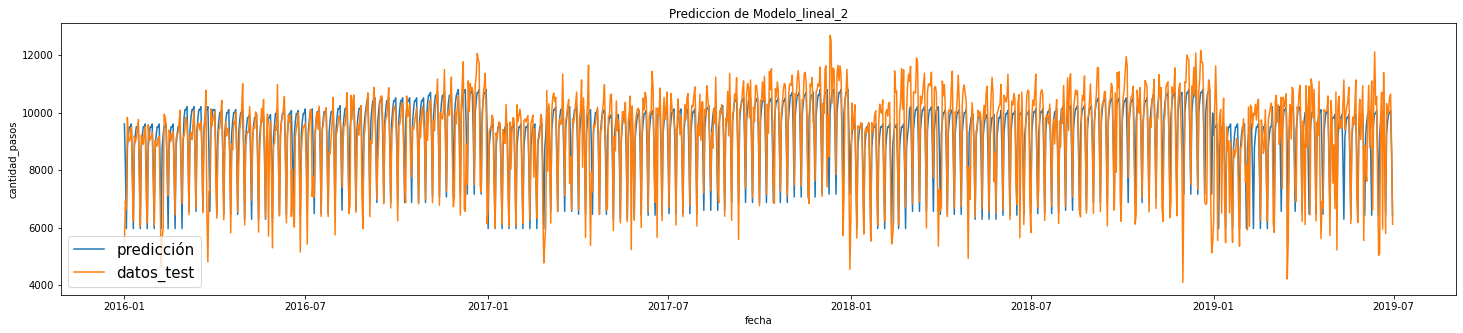

In [66]:
plt.figure(figsize=(25,5))
plt.plot(predicciones_modelo_lineal,label='predicción')
plt.plot(data_series,label='datos_test')
plt.ylabel('cantidad_pasos')
plt.xlabel('fecha')
plt.title('Prediccion de Modelo_lineal_2')
plt.legend(loc="lower left",prop={'size': 15})

### Colclusion modelos lineales

Ambos modelos se comportan de forma similar y es de esperarse ya que no hay tanas diferencias entre sus features. Seria interesante agregar datos sobre los dia feriados para mejorar el modelo.

En cuanto al analisis de los residuos ambos tienen medias cercanas a 0 pero las distribuciones no son normales como se ve en los QQplot. Los intervalos de confianza y p-value de los coeficientes no son confiable. 

## Prediccion

Dada la simplicidad y que tuvo  una mejor performance que los modelos SARIMA se utiliza el primer modelo lineal para predecir los datos de Julio a Diciembre de 2019. Este es el modelo que unicamente con varaibles dummies del dia y el mes.

In [67]:
index_predicciones = pd.DataFrame(index=data[data.cantidad_pasos.isnull()].fecha.astype(np.datetime64).values).index

In [68]:
features_predicciones = pd.DataFrame(index = index_predicciones, data={'dia_semana':index_predicciones.dayofweek,'mes':index_predicciones.month,
                                                         'cte':np.ones(len(index_predicciones))})
features_predicciones = pd.get_dummies(data=features_predicciones,columns=['dia_semana'],drop_first=True)
features_predicciones = pd.get_dummies(data=features_predicciones,columns=['mes'],drop_first=False)

features_predicciones['mes_3'] = np.zeros(features_predicciones.shape[0])
features_predicciones['mes_4'] = np.zeros(features_predicciones.shape[0])
features_predicciones['mes_5'] = np.zeros(features_predicciones.shape[0])
features_predicciones['mes_6'] = np.zeros(features_predicciones.shape[0])
features_predicciones = features_predicciones.loc[:,features.columns]

features_predicciones

,cte,dia_semana_1,dia_semana_2,dia_semana_3,dia_semana_4,dia_semana_5,dia_semana_6,mes_3,mes_4,mes_5,mes_6,mes_7,mes_8,mes_9,mes_10,mes_11,mes_12
2019-07-01,1.0,0,0,0,0,0,0,0.0,0.0,0.0,0.0,1,0,0,0,0,0
2019-07-02,1.0,1,0,0,0,0,0,0.0,0.0,0.0,0.0,1,0,0,0,0,0
2019-07-03,1.0,0,1,0,0,0,0,0.0,0.0,0.0,0.0,1,0,0,0,0,0
2019-07-04,1.0,0,0,1,0,0,0,0.0,0.0,0.0,0.0,1,0,0,0,0,0
2019-07-05,1.0,0,0,0,1,0,0,0.0,0.0,0.0,0.0,1,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2019-12-27,1.0,0,0,0,1,0,0,0.0,0.0,0.0,0.0,0,0,0,0,0,1
2019-12-28,1.0,0,0,0,0,1,0,0.0,0.0,0.0,0.0,0,0,0,0,0,1
2019-12-29,1.0,0,0,0,0,0,1,0.0,0.0,0.0,0.0,0,0,0,0,0,1
2019-12-30,1.0,0,0,0,0,0,0,0.0,0.0,0.0,0.0,0,0,0,0,0,1


In [69]:
modelo_lineal_respuesta = sm.OLS(data_series,features).fit()

In [70]:
predictions_pregunta_g = modelo_lineal_respuesta.predict(features_predicciones)

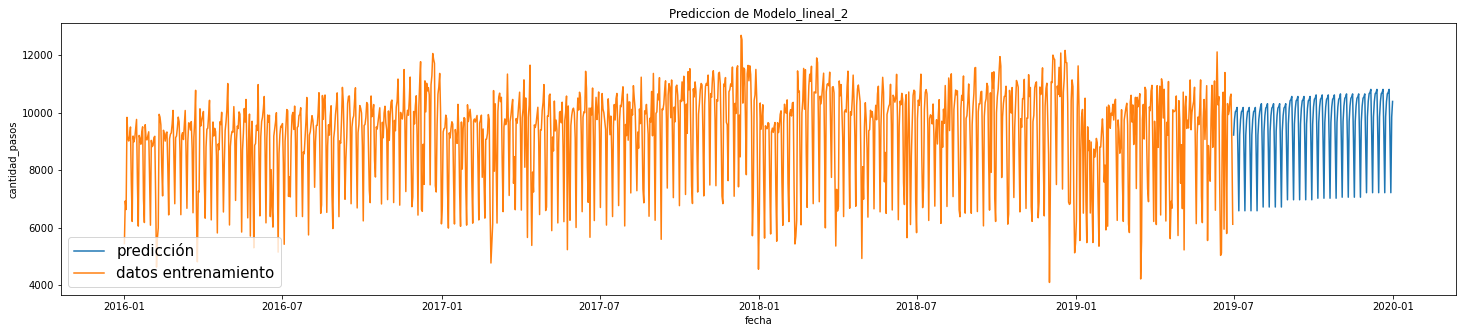

In [71]:
plt.figure(figsize=(25,5))
plt.plot(predictions_pregunta_g,label='predicción')
plt.plot(data_series,label='datos entrenamiento')
plt.ylabel('cantidad_pasos')
plt.xlabel('fecha')
plt.title('Prediccion de Modelo_lineal_2')
plt.legend(loc="lower left",prop={'size': 15})

In [72]:
predictions_pregunta_g

2019-07-01     9219.782876
2019-07-02     9760.142530
2019-07-03    10028.093359
2019-07-04    10072.815571
2019-07-05    10178.972616
                  ...     
2019-12-27    10807.975995
2019-12-28     9188.519945
2019-12-29     7214.696963
2019-12-30     9848.786254
2019-12-31    10389.145909
Length: 184, dtype: float64

In [73]:
predictions_pregunta_g_df = pd.DataFrame(np.round(predictions_pregunta_g).astype(int),columns=['cantidad_pasos'])
predictions_pregunta_g_df['index'] = np.arange(1277,1277+predictions_pregunta_g_df.shape[0])
predictions_pregunta_g_df['fecha'] = predictions_pregunta_g_df.index.astype(str)
predictions_pregunta_g_df.set_index('index',inplace=True)
predictions_pregunta_g_df.index.name = ''
predictions_pregunta_g_df['estacion'] = 'alberdi'
predictions_pregunta_g_df = predictions_pregunta_g_df.loc[:,['estacion','fecha','cantidad_pasos']]
predictions_pregunta_g_df.to_csv('predicciones_julio_diciembre_2019_modelo.csv')